In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# [Image Pyramids](https://docs.opencv.org/3.4/dc/dff/tutorial_py_pyramids.html)

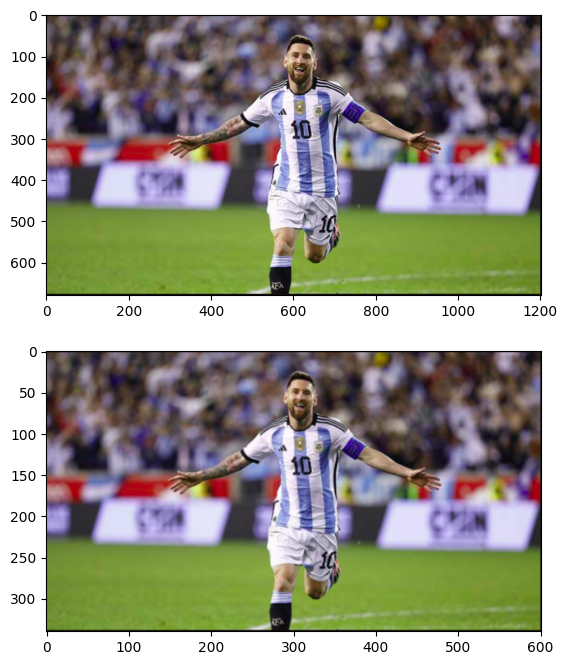

In [2]:
img = cv.imread('..\img\messi.png')
assert img is not None, "file could not be read, check with os.path.exists()"
lower_reso = cv.pyrDown(img)

fig, ax = plt.subplots(2, 1, figsize=(8, 8))
ax[0].imshow(img[..., ::-1])
ax[1].imshow(lower_reso[..., ::-1])
plt.show()

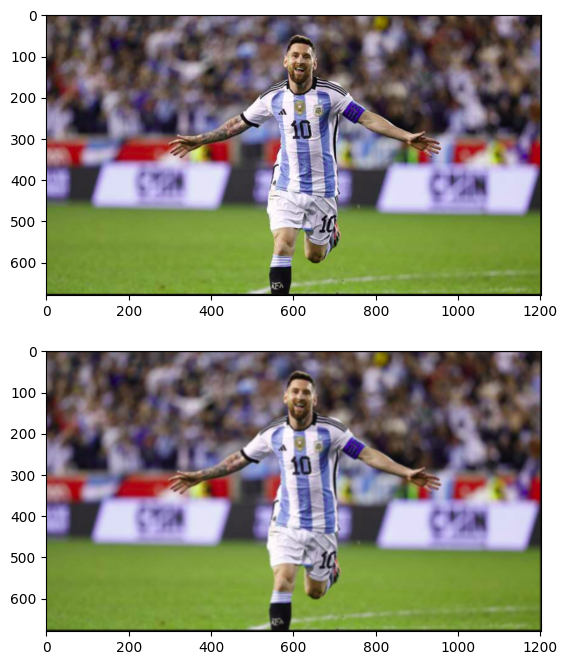

In [3]:
higher_reso2 = cv.pyrUp(lower_reso)

fig, ax = plt.subplots(2, 1, figsize=(8, 8))
ax[0].imshow(img[..., ::-1])
ax[1].imshow(higher_reso2[..., ::-1])
plt.show()

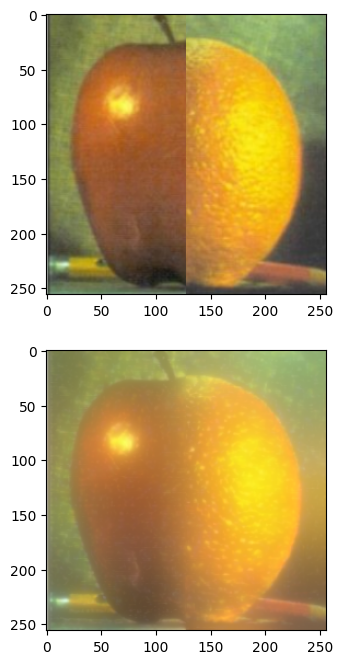

In [4]:
A = cv.imread('../img/apple.png')
B = cv.imread('../img/orange.png')
assert A is not None, "file could not be read, check with os.path.exists()"
assert B is not None, "file could not be read, check with os.path.exists()"
# generate Gaussian pyramid for A

A = cv.resize(A, (256, 256))
B = cv.resize(B, (256, 256))
G = A.copy()
gpA = [G]
for i in range(6):
    G = cv.pyrDown(G)
    gpA.append(G)
# generate Gaussian pyramid for B
G = B.copy()
gpB = [G]
for i in range(6):
    G = cv.pyrDown(G)
    gpB.append(G)
# generate Laplacian Pyramid for A
lpA = [gpA[5]]
for i in range(5,0,-1):
    GE = cv.pyrUp(gpA[i])
    L = cv.subtract(gpA[i-1],GE)
    lpA.append(L)
# generate Laplacian Pyramid for B
lpB = [gpB[5]]
for i in range(5,0,-1):
    GE = cv.pyrUp(gpB[i])
    L = cv.subtract(gpB[i-1],GE)
    lpB.append(L)
# Now add left and right halves of images in each level
LS = []
for la,lb in zip(lpA,lpB):
    rows,cols,dpt = la.shape
    ls = np.hstack((la[:,0:cols//2], lb[:,cols//2:]))
    LS.append(ls)
# now reconstruct
ls_ = LS[0]
for i in range(1,6):
    ls_ = cv.pyrUp(ls_)
    ls_ = cv.add(ls_, LS[i])
# image with direct connecting each half
real = np.hstack((A[:,:cols//2],B[:,cols//2:]))

fig, ax = plt.subplots(2, 1, figsize=(8, 8))
ax[0].imshow(real[..., ::-1])
ax[1].imshow(ls_[..., ::-1])
plt.show()

# [Image Segmentation with Watershed Algorithm](https://docs.opencv.org/3.4/d3/db4/tutorial_py_watershed.html)


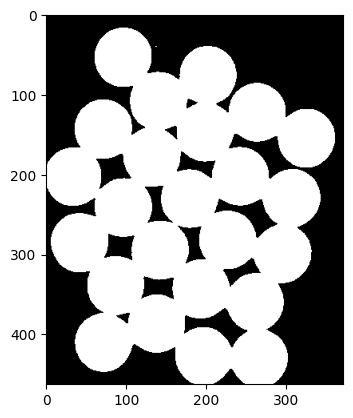

In [5]:
img = cv.imread('..\img\coins.png')
assert img is not None, "file could not be read, check with os.path.exists()"
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

plt.imshow(thresh, cmap="gray")
plt.show()

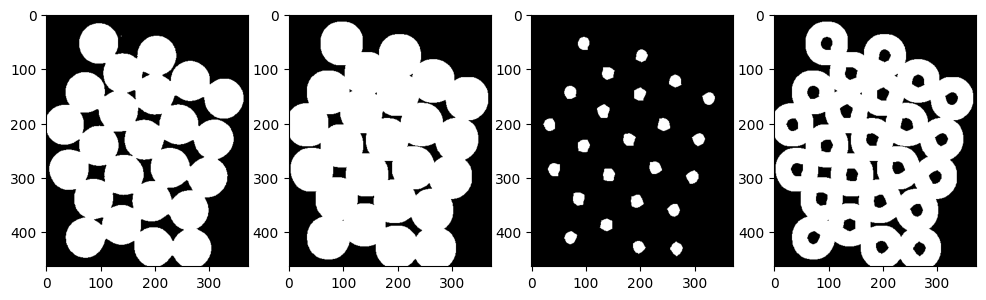

In [8]:
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)

fig, ax = plt.subplots(1, 4, figsize=(12, 8))
ax[0].imshow(thresh, cmap="gray")
ax[1].imshow(sure_bg, cmap="gray")
ax[2].imshow(sure_fg, cmap="gray")
ax[3].imshow(unknown, cmap="gray")
plt.show()

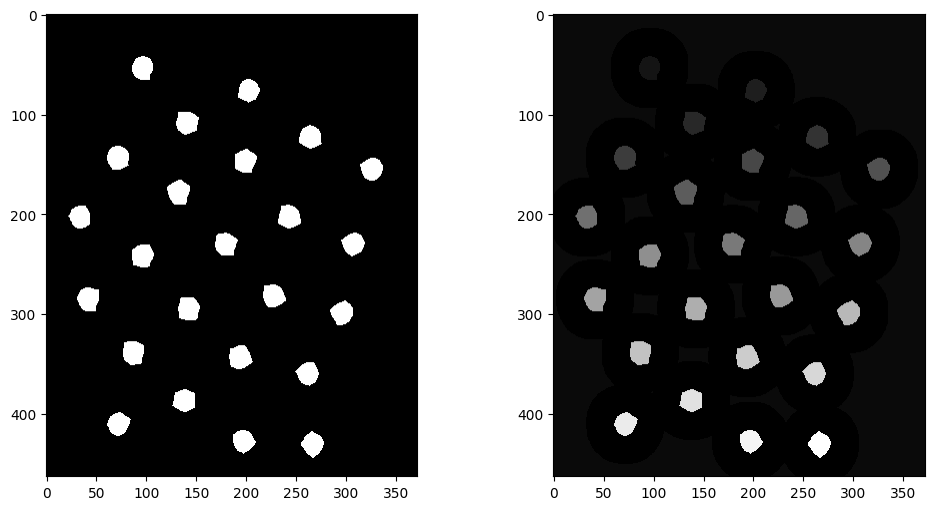

In [19]:
# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(sure_fg, cmap="gray")
ax[1].imshow(markers, cmap="gray")
plt.show()

# [Discrete Fourier Transform](https://docs.opencv.org/4.x/d8/d01/tutorial_discrete_fourier_transform.html)

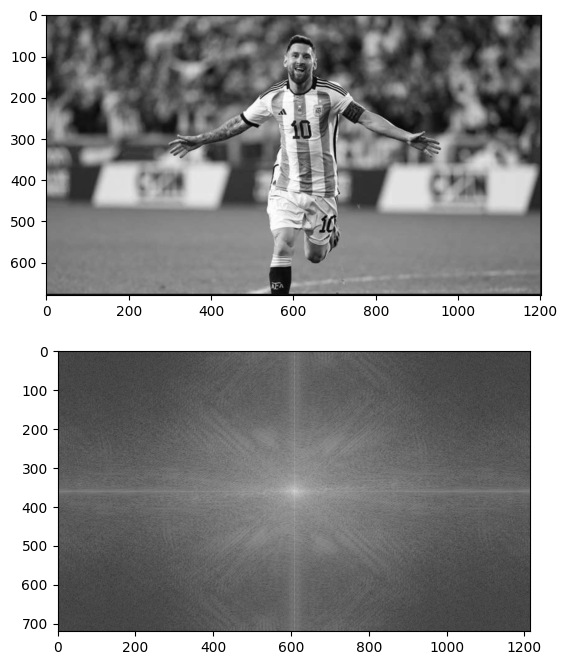

In [23]:
def print_help():
    print('''
    This program demonstrated the use of the discrete Fourier transform (DFT).
    The dft of an image is taken and it's power spectrum is displayed.
    Usage:
    discrete_fourier_transform.py [image_name -- default lena.jpg]''')

# print_help()

I = cv.imread(cv.samples.findFile('..\img\messi.png'), cv.IMREAD_GRAYSCALE)
if I is None:
    print('Error opening image')
    exit()


rows, cols = I.shape
m = cv.getOptimalDFTSize( rows )
n = cv.getOptimalDFTSize( cols )
padded = cv.copyMakeBorder(I, 0, m - rows, 0, n - cols, cv.BORDER_CONSTANT, value=[0, 0, 0])

planes = [np.float32(padded), np.zeros(padded.shape, np.float32)]
complexI = cv.merge(planes) # Add to the expanded another plane with zeros

cv.dft(complexI, complexI) # this way the result may fit in the source matrix

cv.split(complexI, planes) # planes[0] = Re(DFT(I), planes[1] = Im(DFT(I))
cv.magnitude(planes[0], planes[1], planes[0])# planes[0] = magnitude
magI = planes[0]

matOfOnes = np.ones(magI.shape, dtype=magI.dtype)
cv.add(matOfOnes, magI, magI) # switch to logarithmic scale
cv.log(magI, magI)

magI_rows, magI_cols = magI.shape
# crop the spectrum, if it has an odd number of rows or columns
magI = magI[0:(magI_rows & -2), 0:(magI_cols & -2)]
cx = int(magI_rows/2)
cy = int(magI_cols/2)

q0 = magI[0:cx, 0:cy] # Top-Left - Create a ROI per quadrant
q1 = magI[cx:cx+cx, 0:cy] # Top-Right
q2 = magI[0:cx, cy:cy+cy] # Bottom-Left
q3 = magI[cx:cx+cx, cy:cy+cy] # Bottom-Right

tmp = np.copy(q0) # swap quadrants (Top-Left with Bottom-Right)
magI[0:cx, 0:cy] = q3
magI[cx:cx + cx, cy:cy + cy] = tmp

tmp = np.copy(q1) # swap quadrant (Top-Right with Bottom-Left)
magI[cx:cx + cx, 0:cy] = q2
magI[0:cx, cy:cy + cy] = tmp

cv.normalize(magI, magI, 0, 1, cv.NORM_MINMAX) # Transform the matrix with float values into a

fig, ax = plt.subplots(2, 1, figsize=(8, 8))
ax[0].imshow(I, cmap="gray")
ax[1].imshow(magI, cmap="gray")
plt.show()
